In [1]:
import pandas as pd
import itertools
import json

In [2]:
# Cargamos las alarmas
with open("alarm_config.json") as f:
    alarmas = json.load(f)

# Crear DataFrame base
df = pd.DataFrame([
    {
        "tag": a["tag"],
        "type": a["source"]["type"],
        "address": a["source"]["address"],
        "severity": a["severity"],
        "message": a["message"]
    }
    for a in alarmas
])

In [3]:
edges = []
for (i, a1), (j, a2) in itertools.combinations(df.iterrows(), 2):
    weight = 0
    if any(t in a1.tag and t in a2.tag for t in ["T0", "T1", "T2"]):
        weight += 1  # más fuerte
    if a1.severity == a2.severity:
        weight += 2
    
    if weight > 0:
        edges.append((a1.tag, a2.tag, weight))

edges_df = pd.DataFrame(edges, columns=["source", "target", "weight"])
edges_df.to_csv("alarm_edges.csv", index=False)


### Crear Grafo Node2Vec

In [4]:
import pandas as pd
import networkx as nx

# Cargar los edges guardados antes
edges_df = pd.read_csv("alarm_edges.csv")

# Crear el grafo no direccional
G = nx.from_pandas_edgelist(edges_df, source="source", target="target", edge_attr="weight")

print(f"Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}")

Nodos: 20, Aristas: 91


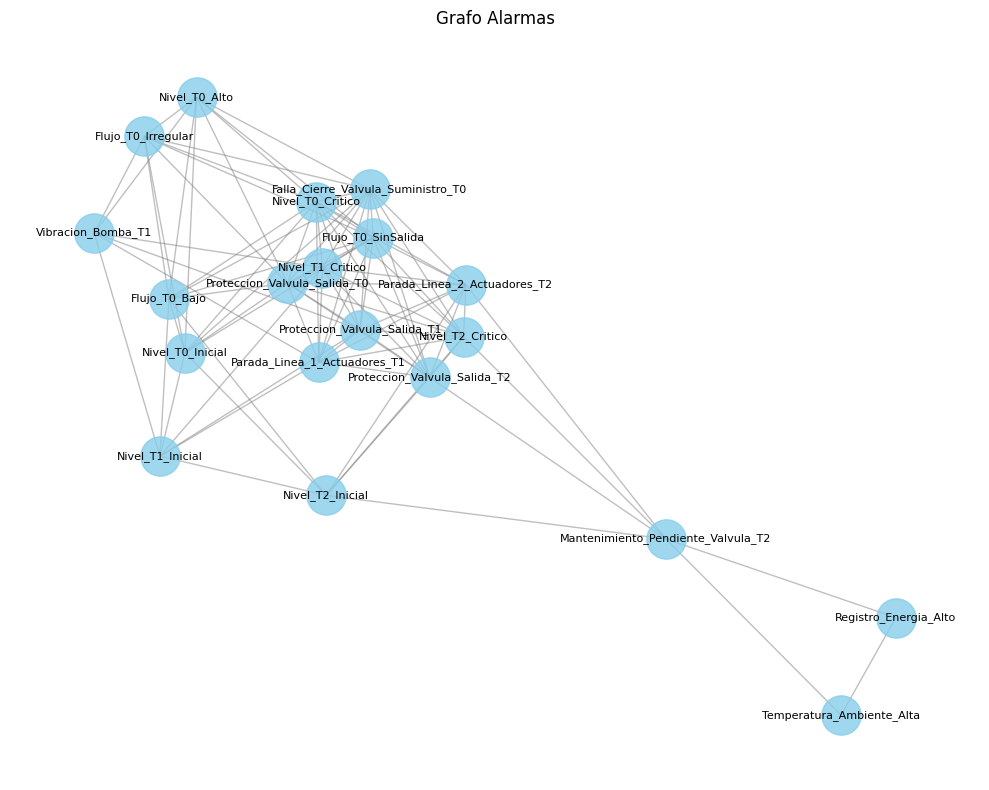

In [5]:
import matplotlib.pyplot as plt
# Calcular la disposición de los nodos (layout)
pos = nx.spring_layout(G, k=0.4, iterations=50, seed=42)

# Dibujar el grafo
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=800, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")

plt.title("Grafo Alarmas", fontsize=12)
plt.axis("off")

# Guardar el gráfico en alta calidad
plt.tight_layout()
plt.savefig("grafo_alarmas.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
from node2vec import Node2Vec

# Entrenar Node2Vec usando los pesos
node2vec = Node2Vec(
    G,
    dimensions=16,       # o 32, según quieras más detalle
    walk_length=10,
    num_walks=20,
    workers=2,
    weight_key='weight'  # <- clave: usa los pesos del grafo
)

model = node2vec.fit(window=5, min_count=1)

c:\Users\luisl\Tesis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing transition probabilities: 100%|██████████| 20/20 [00:00<00:00, 5592.03it/s]


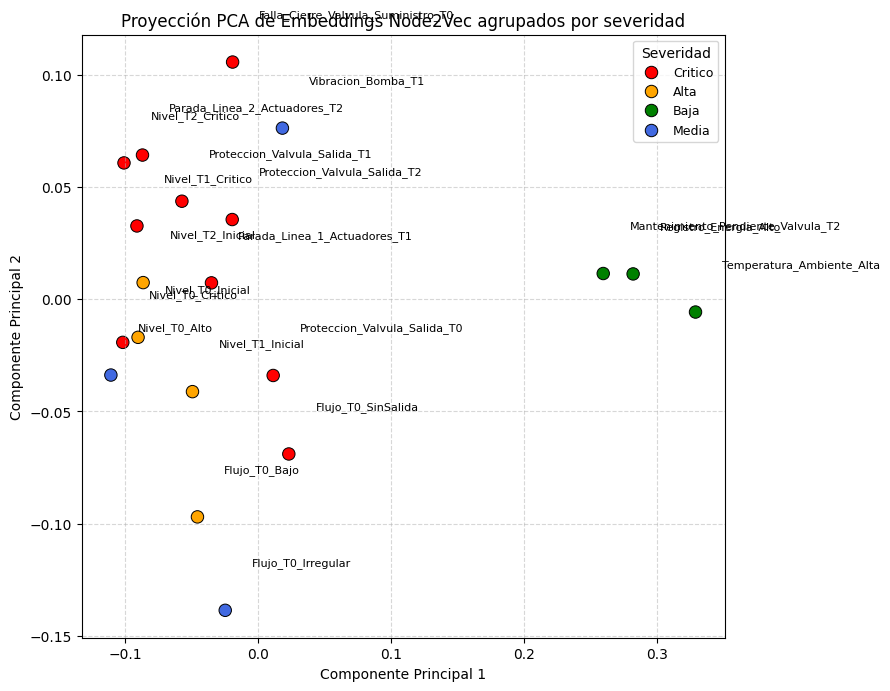

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns
nodes = list(model.wv.index_to_key)
alarm_df = pd.DataFrame([
    {"tag": a["tag"], "severity": a["severity"]}
    for a in alarmas
])

X = model.wv.vectors  # matriz de embeddings
# Reducir a 2D con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# === 5. Crear DataFrame final para graficar ===
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["tag"] = nodes

# Unir severidades
df_pca = df_pca.merge(alarm_df, on="tag", how="left")

# === 6. Graficar ===
plt.figure(figsize=(9,7))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="severity",
    palette={
        "Critico": "red",
        "Alta": "orange",
        "Media": "royalblue",
        "Baja": "green"
    },
    s=80, edgecolor="black"
)

# Añadir etiquetas pequeñas a los puntos
for i, tag in enumerate(df_pca["tag"]):
    plt.text(
        df_pca["PC1"][i]+0.02,
        df_pca["PC2"][i]+0.02,
        tag,
        fontsize=8
    )

plt.title("Proyección PCA de Embeddings Node2Vec agrupados por severidad", fontsize=12)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Severidad", fontsize=9)
plt.tight_layout()
plt.show()

In [8]:
embeddings = {node: model.wv[node] for node in G.nodes()}
emb_df = pd.DataFrame.from_dict(embeddings, orient="index")
emb_df.reset_index(inplace=True)
emb_df.columns = ["tag"] + [f"dim_{i}" for i in range(1, emb_df.shape[1])]

In [9]:
import numpy as np

nodes = pd.read_csv("alarm_nodes.csv")
merged = pd.merge(nodes, emb_df, on="tag")


### Clustering

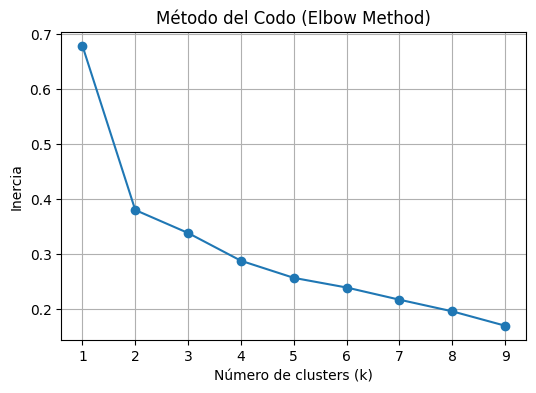

In [10]:

from sklearn.cluster import KMeans
# Usaremos el método de codo para definir el numero de clusters
X = emb_df.iloc[:, 1:]
inertias = []
k_values = range(1, 10)  # Puedes probar de 1 a 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker="o")
plt.title("Método del Codo (Elbow Method)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

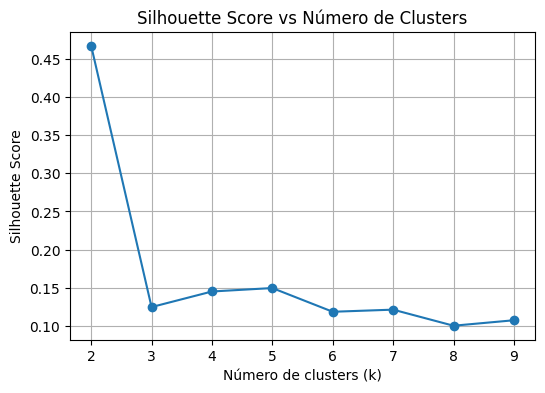

In [11]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), sil_scores, marker="o")
plt.title("Silhouette Score vs Número de Clusters")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [12]:

kmeans = KMeans(n_clusters=2, random_state=42)
merged["cluster"] = kmeans.fit_predict(merged.iloc[:, -16:])

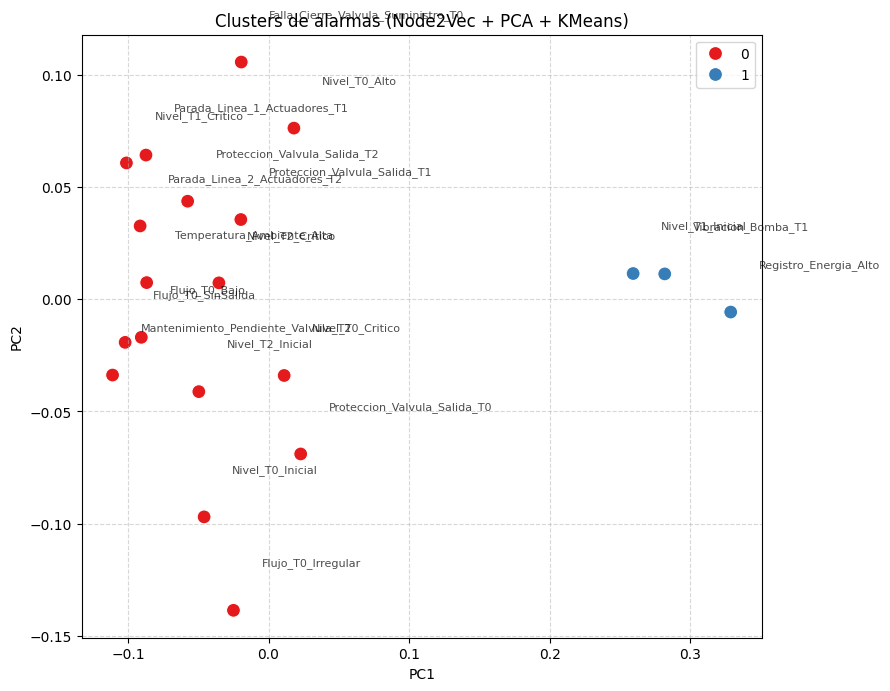

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Crear DataFrame con embeddings (mismo orden que model.wv.index_to_key)
embedding_df = pd.DataFrame(X, index=model.wv.index_to_key)
embedding_df.reset_index(inplace=True)
embedding_df.rename(columns={'index': 'tag'}, inplace=True)

# Unir con etiquetas de cluster
merged = embedding_df.copy()
merged["cluster"] = kmeans.labels_

# Agregar las coordenadas PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
merged["x"] = X_pca[:, 0]
merged["y"] = X_pca[:, 1]
plt.figure(figsize=(9,7))
sns.scatterplot(
    data=merged,
    x="x", y="y",
    hue="cluster",
    palette="Set1",
    s=100
)

# Etiquetas pequeñas junto a cada punto
for _, row in merged.iterrows():
    plt.text(row["x"]+0.02, row["y"]+0.02, row["tag"], fontsize=8, alpha=0.7)

plt.title("Clusters de alarmas (Node2Vec + PCA + KMeans)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

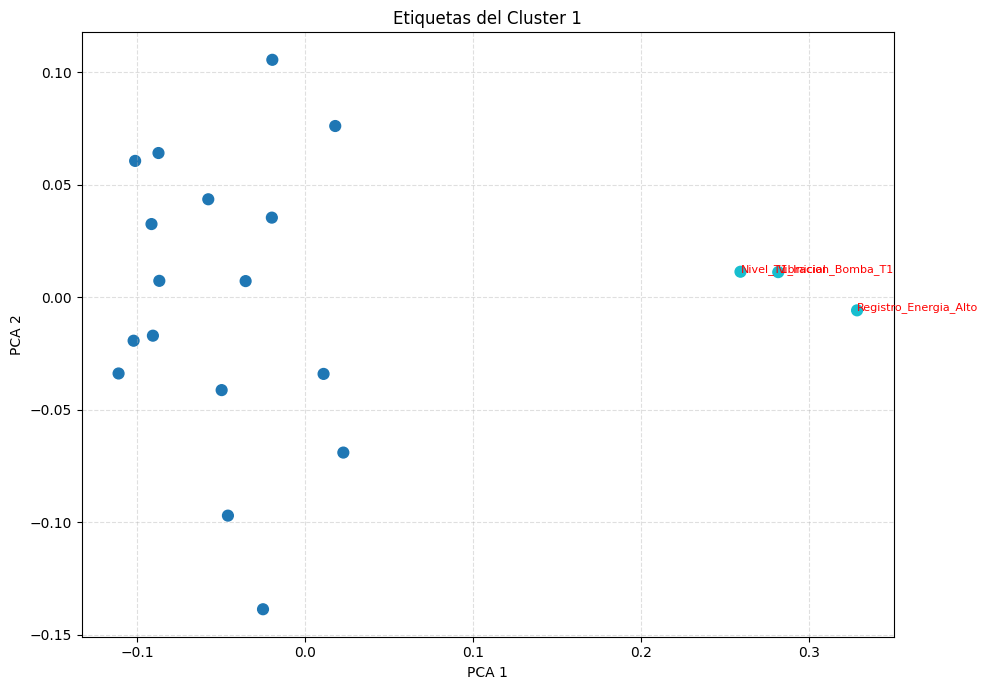

In [14]:
cluster_to_label = 1  # por ejemplo, Cluster 0
subset = merged[merged["cluster"] == cluster_to_label]

plt.figure(figsize=(10, 7))
plt.scatter(merged["x"], merged["y"], c=merged["cluster"], cmap="tab10", s=60)
for _, row in subset.iterrows():
    plt.text(row["x"], row["y"], row["tag"], fontsize=8, color="red")

plt.title(f"Etiquetas del Cluster {cluster_to_label}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

### Predicción Online

In [15]:
embedding_dict = {tag: model.wv[tag] for tag in model.wv.index_to_key}
embedding_dict

{'Falla_Cierre_Valvula_Suministro_T0': array([ 1.1984842e-03,  1.1665287e-01, -1.9938214e-02,  4.0042180e-01,
         1.6246866e-01, -4.0224177e-04,  8.6637568e-01,  2.8799905e-02,
         1.2542106e-01, -8.0308154e-02,  1.6470204e-01, -4.9147554e-02,
         5.9277650e-02,  1.3759039e-01, -5.4313147e-01, -1.7298107e-01],
       dtype=float32),
 'Flujo_T0_SinSalida': array([ 0.0220392 ,  0.12205015, -0.11051852,  0.3112228 ,  0.27494368,
         0.07805279,  0.921316  , -0.02146267,  0.20485167, -0.08314866,
         0.11731054, -0.00931469,  0.04097437,  0.079628  , -0.5860851 ,
        -0.18326843], dtype=float32),
 'Proteccion_Valvula_Salida_T0': array([ 0.06493838,  0.07521583, -0.07154582,  0.35171813,  0.2805368 ,
         0.00947577,  0.861846  , -0.05898352,  0.10591552, -0.02694461,
         0.06536385, -0.06947157,  0.08750485,  0.09904505, -0.5799648 ,
        -0.11246403], dtype=float32),
 'Nivel_T0_Critico': array([ 0.03781506,  0.1624374 , -0.10047242,  0.3520413 ,  0

In [16]:
def clasificar_alarma(tag):
    if tag not in embedding_dict:
        print(f"⚠️ La alarma '{tag}' no existe en los embeddings.")
        return None
    # Obtener embedding de la alarma
    vec = embedding_dict[tag].reshape(1, -1)
    
    # Predecir a qué cluster pertenece
    cluster = kmeans.predict(vec)[0]
    
    print(f"🔸 La alarma '{tag}' pertenece al cluster {cluster}")
    return cluster

In [17]:
def alarma_filtrada(tag):

    if tag not in embedding_dict:
        print(f"⚠️ La alarma '{tag}' no existe en los embeddings.")
        return None
    cluster = clasificar_alarma(tag)
    return cluster == 1


In [18]:
alarma_filtrada("Nivel_T0_Critico")

🔸 La alarma 'Nivel_T0_Critico' pertenece al cluster 0


c:\Users\luisl\Tesis\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


False

### Fuzzy Clustering

In [80]:
import re
import numpy as np
import pandas as pd

# Mapas de codificación
severity_map = {"Baja": 1, "Media": 2, "Alta": 3, "Critico": 4}
type_map = {"IR": 1, "HR": 2, "CO": 3}

# Extraer features del tag
rows = []
for a in alarmas:
    tag = a["tag"]
    
    # Detectar palabra clave de variable (primer término)
    variable = tag.split("_")[0]
    
    # Detectar tanque (T0, T1, T2)
    tanque_match = re.search(r"T\d", tag)
    tanque = tanque_match.group(0) if tanque_match else "N/A"
    
    # Detectar última palabra como contexto
    contexto = tag.split("_")[-1]
    
    rows.append({
        "severity": severity_map[a["severity"]],
        "type": type_map[a["source"]["type"]],
        "variable": variable,
        "tanque": tanque,
        "contexto": contexto
    })

df = pd.DataFrame(rows)
df.head()

,severity,type,variable,tanque,contexto
0,4,2,Falla,T0,T0
1,4,1,Nivel,T0,Critico
2,4,1,Flujo,T0,SinSalida
3,4,2,Proteccion,T0,T0
4,4,1,Nivel,T1,Critico


In [81]:
for col in ["variable", "tanque", "contexto"]:
    df[col] = df[col].astype("category").cat.codes


weights = {
    "severity": 3.0,   
    "type": 1,
    "variable": 1.2,
    "tanque": 1,
    "contexto": 1
}

for col, w in weights.items():
    df[col] = df[col] * w


data = df[["severity", "type", "variable", "tanque", "contexto"]].to_numpy()
print(data)

[[12.   2.   0.   1.   7. ]
 [12.   1.   3.6  1.   3. ]
 [12.   1.   1.2  1.   6. ]
 [12.   2.   6.   1.   7. ]
 [12.   1.   3.6  2.   3. ]
 [12.   2.   6.   2.   8. ]
 [12.   1.   3.6  3.   3. ]
 [12.   2.   6.   3.   9. ]
 [12.   3.   4.8  2.   8. ]
 [12.   3.   4.8  3.   9. ]
 [ 9.   1.   3.6  1.   4. ]
 [ 9.   1.   1.2  1.   2. ]
 [ 9.   1.   3.6  2.   4. ]
 [ 9.   1.   3.6  3.   4. ]
 [ 6.   1.   3.6  1.   1. ]
 [ 6.   1.   1.2  1.   5. ]
 [ 6.   2.   9.6  2.   8. ]
 [ 3.   1.   8.4  0.   0. ]
 [ 3.   3.   2.4  3.   9. ]
 [ 3.   2.   7.2  0.   1. ]]


In [82]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import seaborn as sns

# Transponer la matriz, FCM espera features en columnas y muestras en filas
data_T = data.T

# Número de clusters (puedes probar con 2 o 3)
n_clusters = 2

# Ejecutar Fuzzy C-Means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_T, c=n_clusters, m=2, error=0.005, maxiter=1000
)

# 'u' son los grados de pertenencia (matriz [n_clusters x n_muestras])
print("Grados de pertenencia (primeras filas):\n", u[:, :5].round(3))
print(f"\nCoeficiente de partición difusa (FPC): {fpc:.4f}")

Grados de pertenencia (primeras filas):
 [[0.243 0.335 0.205 0.087 0.319]
 [0.757 0.665 0.795 0.913 0.681]]

Coeficiente de partición difusa (FPC): 0.6534


In [83]:
df.head()

,severity,type,variable,tanque,contexto
0,12.0,2,0.0,1,7
1,12.0,1,3.6,1,3
2,12.0,1,1.2,1,6
3,12.0,2,6.0,1,7
4,12.0,1,3.6,2,3


In [84]:
# Cluster dominante por alarma
cluster_labels = np.argmax(u, axis=0)

df["cluster"] = cluster_labels
print(df[["severity", "type", "variable", "cluster"]].head())

   severity  type  variable  cluster
0      12.0     2       0.0        1
1      12.0     1       3.6        1
2      12.0     1       1.2        1
3      12.0     2       6.0        1
4      12.0     1       3.6        1


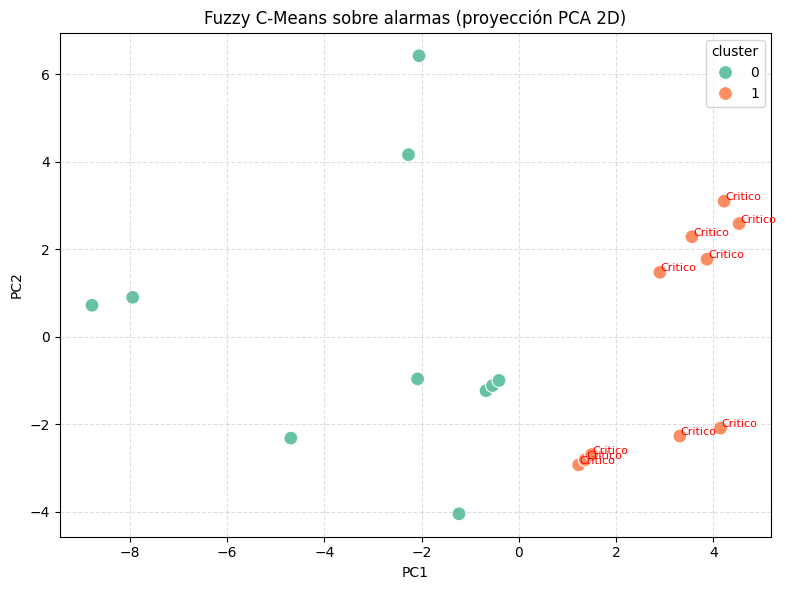

In [92]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reducir dimensionalidad
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

# Crear gráfico
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=df["cluster"],
    palette="Set2",
    s=100
)

# Etiquetar solo las alarmas críticas
for i in range(len(df)):
    if df.loc[i, "severity"] == 12:
        plt.text(
            X_pca[i,0] + 0.02, 
            X_pca[i,1] + 0.02, 
            "Critico", 
            fontsize=8, 
            color="red"
        )

plt.title("Fuzzy C-Means sobre alarmas (proyección PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [45]:
import pandas as pd
import json

with open("alarm_config.json") as f:
    alarmas = json.load(f)

df = pd.DataFrame([
    {
        "tag": a["tag"],
        "severity": a["severity"],
        "type": a["source"]["type"]
    }
    for a in alarmas
])

In [59]:
# Convertir la matriz de pertenencias 'u' en un DataFrame
u_df = pd.DataFrame(u.T, columns=[f"μ_cluster_{i}" for i in range(u.shape[0])])
u_df["tag"] = df["tag"]

# Combinar con df original
merged = pd.concat([df, u_df], axis=1)

# Mostrar los primeros resultados
merged.head(20)

,tag,severity,type,μ_cluster_0,μ_cluster_1,tag
0,Falla_Cierre_Valvula_Suministro_T0,Critico,HR,0.270561,0.729439,Falla_Cierre_Valvula_Suministro_T0
1,Nivel_T0_Critico,Critico,IR,0.394445,0.605555,Nivel_T0_Critico
2,Flujo_T0_SinSalida,Critico,IR,0.242547,0.757453,Flujo_T0_SinSalida
3,Proteccion_Valvula_Salida_T0,Critico,HR,0.082252,0.917748,Proteccion_Valvula_Salida_T0
4,Nivel_T1_Critico,Critico,IR,0.378311,0.621689,Nivel_T1_Critico
5,Proteccion_Valvula_Salida_T1,Critico,HR,0.079336,0.920664,Proteccion_Valvula_Salida_T1
6,Nivel_T2_Critico,Critico,IR,0.373688,0.626312,Nivel_T2_Critico
7,Proteccion_Valvula_Salida_T2,Critico,HR,0.122521,0.877479,Proteccion_Valvula_Salida_T2
8,Parada_Linea_1_Actuadores_T1,Critico,CO,0.059852,0.940148,Parada_Linea_1_Actuadores_T1
9,Parada_Linea_2_Actuadores_T2,Critico,CO,0.108863,0.891137,Parada_Linea_2_Actuadores_T2


In [64]:
merged.columns

Index(['tag', 'severity', 'type', 'μ_cluster_0', 'μ_cluster_1', 'tag'], dtype='object')

In [76]:
merged = merged.loc[:, ~merged.columns.duplicated()]
merged["cluster_fuzzy"] = merged[["μ_cluster_0", "μ_cluster_1"]].idxmax(axis=1)
merged.to_csv("alarm_clusters.csv", index=False, encoding="utf-8")
print("Archivo guardado como alarm_clusters.csv ✅")


Archivo guardado como alarm_clusters.csv ✅


In [75]:
tag = "Registro_Energia_Alto"

def get_cluster(tag):
    fila = merged[merged["tag"] == tag]
    
    if not fila.empty:
        cluster_name = fila["cluster_fuzzy"].iloc[0]  # obtener el valor de la fila
        if cluster_name == "μ_cluster_1":
            print(f"La alarma '{tag}' pertenece al cluster 1")
            return 1
        else:
            print(f"La alarma '{tag}' pertenece al cluster 0")
            return 0
    else:
        print("Alarma no encontrada (posiblemente nueva)")
        return None

get_cluster(tag)

La alarma 'Registro_Energia_Alto' pertenece al cluster 0


0